# Perform regionalization when no parameter set is available

Here we call the Regionalization WPS service to provide estimated streamflow (best estimate and ensemble) at an ungauged site using three pre-calibrated hydrological models and a large hydrometeorological database with catchment attributes (Extended CANOPEX). Multiple regionalization strategies are allowed. 

In [1]:
import datetime as dt
import json
import os
from urllib.request import urlretrieve

import numpy as np
import xarray as xr
from birdy import WPSClient
from matplotlib import pyplot as plt
from ravenpy.utilities.testdata import get_file

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(url)

In [2]:
# Get the documentation for the method's usage:
help(wps.regionalisation)

Help on method regionalisation in module birdy.client.base:

regionalisation(ts, model_name=None, properties=None, start_date=datetime.datetime(1, 1, 1, 0, 0), end_date=datetime.datetime(1, 1, 1, 0, 0), latitude=None, longitude=None, rain_snow_fraction=None, nc_spec=None, ndonors=5, min_nse=0.6, method='SP_IDW', area=0.0, elevation=None, output_formats=None) method of birdy.client.base.WPSClient instance
    Compute the hydrograph for an ungauged catchment using a regionalization method.
    
    Parameters
    ----------
    ts : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`, :mimetype:`text/plain`, :mimetype:`application/x-zipped-shp`
        Files (text or netCDF) storingdaily liquid precipitation (pr), solid precipitation (prsn), minimum temperature (tasmin), maximum temperature (tasmax), potential evapotranspiration (evspsbl) and observed streamflow (qobs [m3/s]).
    start_date : dateTime
        Start date of the simulation (AAAA-MM-DD). Default

In [3]:
# Forcing files. This file should only contain weather data (tmin, tmax, rain, snow, pet (if desired), etc.
# No streamflow is required. This is a link to a string, but you can submit a string to your netcdf file directly.
ts = str(
    get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")
)

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    method="PS",  # One of the methods described above
    model_name="HMETS",  # One of the three models are allowed: HMETS, GR4JCN and MOHYSE
    min_nse=0.7,  # Minimumcalibration NSE required to be considered a donor (for selecting good donor catchments)
    ndonors=5,  # Number of donors we want to use. Usually between 4 and 8 is a robust number.
    properties=json.dumps({"latitude": 54.4848, "longitude": -123.3659, "forest": 0.4}),
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.regionalisation(ts=ts, **config)

In [4]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, ensemble] = resp.get(asobj=True)

The `hydrograph` and `ensemble` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [5]:
print(hydrograph.q_sim)

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[  0.      ],
       [331.471505],
       [641.095766],
       ...,
       [ 20.079356],
       [ 19.626541],
       [ 19.194768]])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows


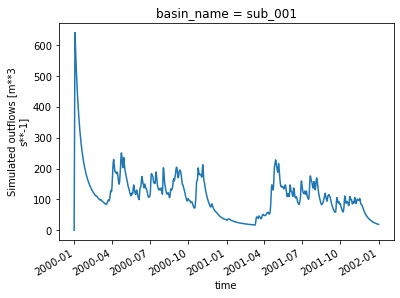

In [6]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

hydrograph.q_sim.plot()

In [7]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby("time.month").mean(dim="time"))

Max:  <xarray.DataArray 'q_sim' ()>
array(641.09576615)
Mean:  <xarray.DataArray 'q_sim' ()>
array(114.8507452)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[172.76385283],
       [ 76.18857277],
       [ 65.66557725],
       [151.16984984],
       [145.88471373],
       [123.31389115],
       [142.17742226],
       [128.54323994],
       [121.63175241],
       [104.19799177],
       [104.13764708],
       [ 39.80017892]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins


Now we can also see the results coming from the 5 donors using the 'ensemble' variable

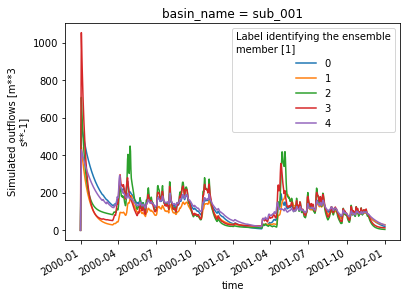

In [8]:
# Plot the simulations from the 5 donor parameter sets
ensemble.q_sim.isel(nbasins=0).plot.line(hue="realization")
plt.show()

In [9]:
# You can also obtain the data in netcdf format directly by changing asobj to False:
[hydrograph_path, ensemble_path] = resp.get(asobj=False)
print(hydrograph)
print(ensemble)

<xarray.Dataset>
Dimensions:     (time: 732, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Data variables:
    q_sim       (time, nbasins) float64 0.0 331.5 641.1 ... 20.08 19.63 19.19
<xarray.Dataset>
Dimensions:      (time: 732, nbasins: 1, realization: 5, param: 21)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name   (nbasins) object ...
  * realization  (realization) int64 0 1 2 3 4
  * param        (param) object 'GAMMA_SHAPE' 'GAMMA_SCALE' ... 'PHREATIC'
Dimensions without coordinates: nbasins
Data variables:
    q_sim        (realization, time, nbasins) float64 ...
    parameter    (realization, param) float64 ...
Attributes:
    title:        Regionalization ensemble
    institution:  
    source:       RAVEN V.3.0.4 - HMETS
    history:      Created by raven regionalize.
    references:   
    c

In [10]:
print(ensemble.q_sim)

<xarray.DataArray 'q_sim' (realization: 5, time: 732, nbasins: 1)>
array([[[  0.      ],
        [286.7841  ],
        ...,
        [ 21.023598],
        [ 20.296133]],

       [[  0.      ],
        [228.646961],
        ...,
        [ 30.265317],
        [ 29.898519]],

       ...,

       [[  0.      ],
        [553.887672],
        ...,
        [ 13.341962],
        [ 13.190296]],

       [[  0.      ],
        [217.590843],
        ...,
        [ 28.63213 ],
        [ 27.848946]]])
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name   (nbasins) object ...
  * realization  (realization) int64 0 1 2 3 4
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows
